In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('../datasets/clean_dataset.csv')

RANDOM_SEED=42

### Algorithm selection

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier, ExtraTreesClassifier, RandomForestClassifier

In [4]:
features = ['close_loans_cnt','federal_district_nm','TraderKey','payment_type_0','payment_type_1','payment_type_2','payment_type_3','payment_type_4','past_billings_cnt','score_1','age','gender','diff_loans']
target = 'bad_flag'

In [5]:
X_train,X_test,y_train,y_test = train_test_split(df[features],df[target],test_size=0.2,stratify=df[target],random_state=RANDOM_SEED)

In [6]:
classifiers = [
    KNeighborsClassifier(),
    LogisticRegression(random_state=RANDOM_SEED),
    BaggingClassifier(random_state=RANDOM_SEED),
    GaussianNB(),
    RandomForestClassifier(n_estimators=100,random_state=RANDOM_SEED),
    ExtraTreesClassifier(n_estimators=100,random_state=RANDOM_SEED)
]

## 1. Experiment 1

#### Undersampling

In [7]:
print(df[df['bad_flag']==1].shape)
print(df[df['bad_flag']==0].shape)

(415, 19)
(3731, 19)


Let's take the 15% of the bad_flag=0 and merge with all the bad_flag=1:

In [8]:
positive=df[df['bad_flag']==1]
negative=df[df['bad_flag']==0].sample(frac=0.15,random_state=RANDOM_SEED)

print(positive.shape)
print(negative.shape)

under_df = pd.concat(objs=[positive,negative])


(415, 19)
(560, 19)


In [9]:
under_X_train,under_X_test,under_y_train,under_y_test = train_test_split(under_df[features],under_df[target],test_size=0.2,random_state=RANDOM_SEED)

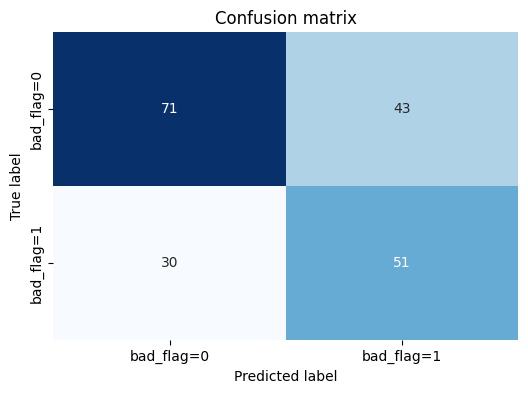

KNeighborsClassifier  f1 score: 0.5828571428571429


d:\Documentos\Proyectos\Data science escritorio\Data science\StrataScratch\CLASIFICACION\Flagging Loans - Mokka\venv\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


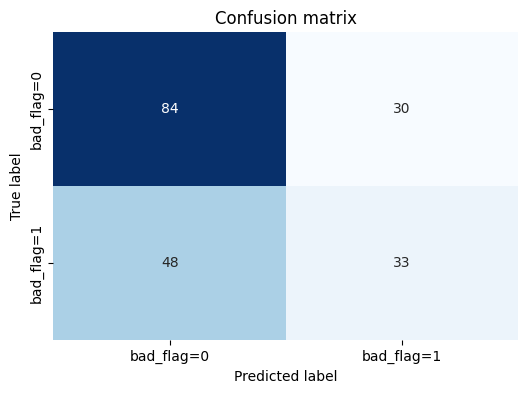

LogisticRegression  f1 score: 0.4583333333333333


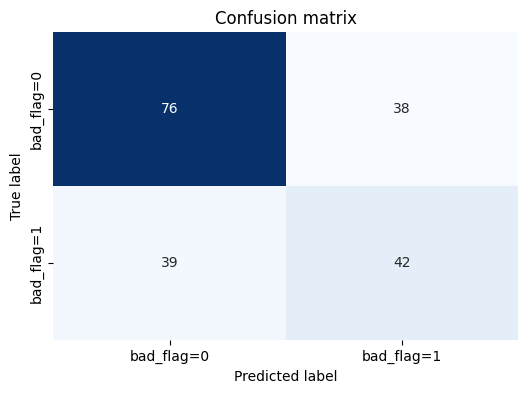

BaggingClassifier  f1 score: 0.5217391304347826


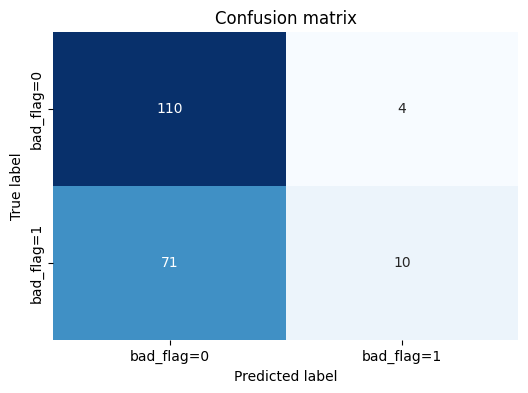

GaussianNB  f1 score: 0.21052631578947367


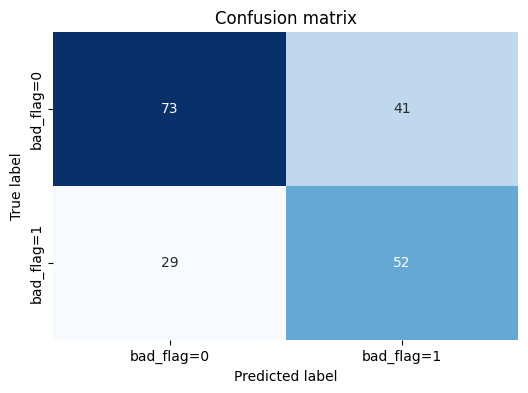

RandomForestClassifier  f1 score: 0.5977011494252873


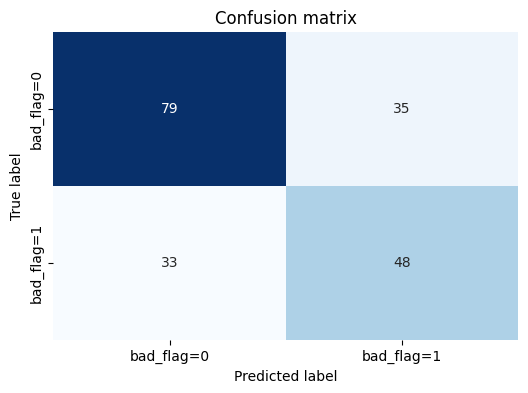

ExtraTreesClassifier  f1 score: 0.5853658536585366


In [10]:
for classifier in classifiers:
    classifier.fit(X=under_X_train, y=under_y_train)
    y_pred = classifier.predict(X=under_X_test)
    f1 = f1_score(y_true=under_y_test, y_pred=y_pred)
    cm = confusion_matrix(under_y_test, y_pred)

    # Definir etiquetas de clase
    classes=["bad_flag=0", "bad_flag=1"]

    # Crear mapa de calor de la matriz de confusión
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=classes, yticklabels=classes)

    plt.title('Confusion matrix')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.show()
    
    print(classifier.__class__.__name__, " f1 score:", f1)

The best f1 score has been obtained by the RandomForest algorithm so we are going to use the hyperparameter optimization:

In [11]:
import optuna 
from sklearn.metrics import roc_curve, auc, accuracy_score


In [12]:
def objective(trial: optuna.Trial):

    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_float('min_samples_split', 0.1, 1.0)
    min_samples_leaf = trial.suggest_float('min_samples_leaf', 0.1, 0.5)


    clf = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=0
    )

    classifier = clf.fit(X=under_X_train, y=under_y_train)
    y_pred = classifier.predict(X=under_X_test)

    return f1_score(y_true=under_y_test, y_pred=y_pred)

In [13]:
sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED)
study = optuna.create_study(direction="maximize",study_name="RandomForest",sampler=sampler)
study.optimize(objective, n_trials=20)

print("Best F1-score: ", study.best_value)
print("Best params: ", study.best_params)

[I 2023-08-01 17:42:59,608] A new study created in memory with name: RandomForest


[I 2023-08-01 17:42:59,799] Trial 0 finished with value: 0.0 and parameters: {'n_estimators': 106, 'max_depth': 15, 'min_samples_split': 0.7587945476302645, 'min_samples_leaf': 0.3394633936788146}. Best is trial 0 with value: 0.0.
[I 2023-08-01 17:42:59,969] Trial 1 finished with value: 0.0 and parameters: {'n_estimators': 73, 'max_depth': 5, 'min_samples_split': 0.15227525095137953, 'min_samples_leaf': 0.4464704583099741}. Best is trial 0 with value: 0.0.
[I 2023-08-01 17:43:00,194] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 140, 'max_depth': 12, 'min_samples_split': 0.1185260448662222, 'min_samples_leaf': 0.4879639408647978}. Best is trial 0 with value: 0.0.
[I 2023-08-01 17:43:00,495] Trial 3 finished with value: 0.5454545454545454 and parameters: {'n_estimators': 175, 'max_depth': 5, 'min_samples_split': 0.26364247048639056, 'min_samples_leaf': 0.17336180394137352}. Best is trial 3 with value: 0.5454545454545454.
[I 2023-08-01 17:43:00,655] Trial 4 finished w

Best F1-score:  0.5477707006369427
Best params:  {'n_estimators': 199, 'max_depth': 10, 'min_samples_split': 0.10636326880120886, 'min_samples_leaf': 0.10395717090159337}


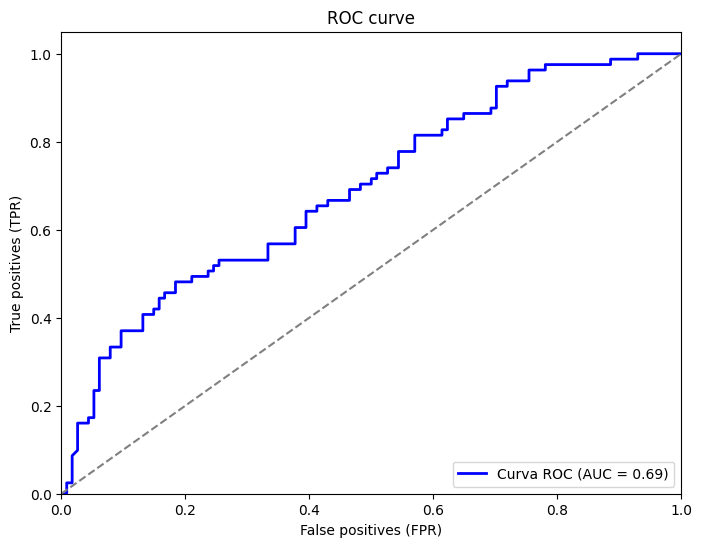

In [14]:
clf = RandomForestClassifier(**study.best_params)

clf.fit(under_X_train, under_y_train)
y_probs = clf.predict_proba(under_X_test)[:, 1]
fpr, tpr, _ = roc_curve(under_y_test, y_probs)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False positives (FPR)')
plt.ylabel('True positives (TPR)')
plt.title('ROC curve')
plt.legend(loc='lower right')
plt.show()

In [15]:
y_pred = classifier.predict(X=under_X_test)
accuracy_score(under_y_test,y_pred=y_pred)

0.6512820512820513